## Init stable diffusion

In [6]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionUpscalePipeline
import torch

def initdiffusionpipeline(model_id):
    # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")
    return pipe

diffusionpipeline=initdiffusionpipeline("stabilityai/stable-diffusion-2-1")


vae\diffusion_pytorch_model.safetensors not found
C:\Users\key\AppData\Roaming\Python\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
def initupscalepipeline(model_id):
    pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipeline.enable_attention_slicing() 
    pipeline = pipeline.to("cuda")
    return pipeline

upscalepipeline=initupscalepipeline("stabilityai/stable-diffusion-x4-upscaler")

vae\diffusion_pytorch_model.safetensors not found


In [8]:
def generate(prompt,seed=42):
    generator = torch.Generator("cuda").manual_seed(seed)
    image = diffusionpipeline(prompt,generator=generator).images[0]
    fname = f"images/{prompt.replace(' ','-')}.png"
    image.save(fname)
    display(image)
    return image

In [9]:
def upscale(prompt,image,seed=42):
    generator = torch.Generator("cuda").manual_seed(seed)
    upscaled_image = upscalepipeline(prompt=prompt, image=image,generator=generator).images[0]
    fname = f"images/{prompt.replace(' ','-')}-upscaled.png"
    upscaled_image.save(fname)
    display(image)  # open inline
    #image.show() # open outside
    return image

## Run

100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


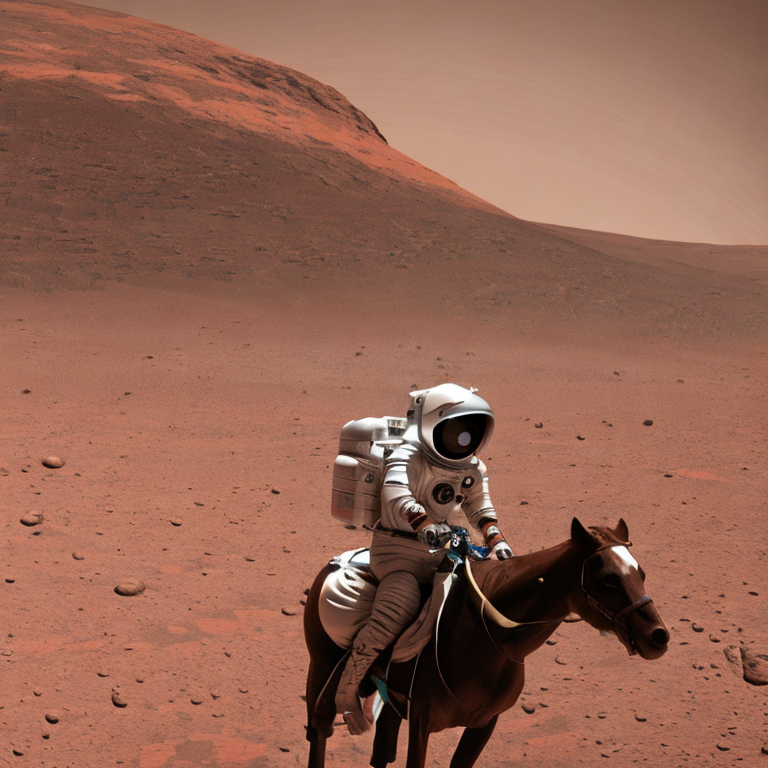

In [10]:
img=generate("a photo of an astronaut riding a horse on mars")

In [ ]:
# upscale("a photo of an astronaut riding a horse on mars",img)